##Librerias

In [42]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import seaborn as sns
import sklearn as sk
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##Realizamos el tratamiento de las variables

from google.colab import drive
drive.mount('/content/drive')

df_hotels_train = pd.read_csv('drive/MyDrive/hotels_train.csv')

In [2]:
df_hotels_train = pd.read_csv('hotels_train.csv')

In [3]:
df_hotels_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [4]:
#Eliminamos las columnas de reservation_status y reservation_status_date para evitar confusiones
df_hotels_train = df_hotels_train.drop(['reservation_status','reservation_status_date'], axis =1) #->Desmarcar al abrir el archivo
df_hotels_train.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

In [5]:
df_hotels_train['hotel'] = df_hotels_train['hotel'].astype('string')
df_hotels_train['arrival_date_month'] = df_hotels_train['arrival_date_month'].astype('string')
df_hotels_train['meal'] = df_hotels_train['meal'].astype('string')
df_hotels_train['country'] = df_hotels_train['country'].astype('string')
df_hotels_train['id'] = df_hotels_train['id'].astype('string')
df_hotels_train['customer_type'] = df_hotels_train['customer_type'].astype('string')
df_hotels_train['market_segment'] = df_hotels_train['market_segment'].astype('string')
df_hotels_train['distribution_channel'] = df_hotels_train['distribution_channel'].astype('string')
df_hotels_train['reserved_room_type'] = df_hotels_train['reserved_room_type'].astype('string')
df_hotels_train['assigned_room_type'] = df_hotels_train['assigned_room_type'].astype('string')
df_hotels_train['deposit_type'] = df_hotels_train['deposit_type'].astype('string')

Retiramos los nulos

In [6]:
#Company
df_hotels_train['company'].fillna(-9999, inplace=True)

In [7]:
#Agent
df_hotels_train['agent'].fillna(-9999, inplace=True)

In [8]:
#Country
df_hotels_train['country'].fillna('PRT', inplace=True)

In [9]:
#Children
df_hotels_train['children'].fillna(0, inplace=True)

Analizamos los outliers

In [10]:
#columnas:(lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces)
media_lead_time=np.mean(df_hotels_train.lead_time)
std_lead_time=np.std(df_hotels_train.lead_time)
df_zscore = pd.DataFrame()
df_zscore['z_lead_time']=(df_hotels_train.lead_time - media_lead_time)/std_lead_time
df_zscore[df_zscore['z_lead_time']>3]


,z_lead_time
15,3.186066
51,3.402834
95,3.086713
426,3.691859
576,4.640223
...,...
61579,3.655731
61695,3.213162
61761,3.466059
61783,3.086713


In [11]:
for i in range(len(df_zscore['z_lead_time'])):
  if df_zscore.z_lead_time[i] > 3:
    df_hotels_train.lead_time[i] = round(media_lead_time)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/3445656125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.lead_time[i] = round(media_lead_time)


In [12]:
#Normalizamos previus cancellation
for i in range(len(df_hotels_train.previous_cancellations)):
  if df_hotels_train.previous_cancellations[i] > 10:
    df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/1879383880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [13]:
media_previous_bookings_not_canceled=np.mean(df_hotels_train.previous_bookings_not_canceled)
for i in range(len(df_hotels_train.previous_bookings_not_canceled)):
  if df_hotels_train.previous_bookings_not_canceled[i] > 30:
    df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/3966743444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)


In [14]:
#Normalizamos los valores atipicos de booking change
for i in range(len(df_hotels_train.booking_changes)):
  if df_hotels_train.booking_changes[i] > 10:
    df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/3893981792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [15]:
media_days_in_waiting_list = np.mean(df_hotels_train.days_in_waiting_list)

for i in range(len(df_hotels_train.days_in_waiting_list)):
  if df_hotels_train.days_in_waiting_list[i] > 100:
    df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/3411085939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)


In [16]:
media_required_car_parking_spaces = np.mean(df_hotels_train.required_car_parking_spaces)

for i in range(len(df_hotels_train.required_car_parking_spaces)):
  if df_hotels_train.required_car_parking_spaces[i] > 7:
    df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/2146687091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)


In [17]:

df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

In [18]:
df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] <= 2 and df_hotels_train.babies[i] >= 8:
    df_hotels_train = df_hotels_train.drop(index = [i])
    

df_hotels_train.reset_index(drop=True, inplace=True)

In [19]:
media_adults=np.mean(df_hotels_train.adults)

for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] >= 25:
    df_hotels_train.adults[i] = round(media_adults)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_12171/842624944.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.adults[i] = round(media_adults)


In [20]:
df_hotels_train.reset_index(drop=True, inplace=True)

for i in range(len(df_hotels_train)):
  if df_hotels_train.stays_in_week_nights[i] == 0 and df_hotels_train.stays_in_weekend_nights[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

Eliminamos id (recordar que la vamos a necesitar mas tarde)

In [21]:
eliminar_columnas = ['id'] # -> Recordar que el id lo vamos a necesitar para machear en kaggle
                                                                      
df_hotels_train.drop(eliminar_columnas, axis='columns', inplace=True)

## Realizamos un encode de las variables

In [22]:
# Realizamos el one hot encoding, con scikit learn.
# Por cada columna a encodear, hacer un fit transform. Dropear la columna, y agregar las columnas nuevas con el nombre adecuado
df_hotels_train_to_encode = df_hotels_train.copy()
cols_a_encodear = ['hotel','arrival_date_month','customer_type','meal', 'distribution_channel','market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'country']
ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist') # Siempre se elimina la primera columna, o el feature entero si solo tiene un valor (no aporta informacion).
transformer = make_column_transformer(
    (ohe, cols_a_encodear),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [23]:
hotels_train_encoded = transformer.fit_transform(df_hotels_train_to_encode.drop('is_canceled', axis=1)) # Se dropea is_canceled, porque no hace falta encodearlo, y ademas la instancia de test no va a tener esa columna.

In [24]:
df_hotels_train_encoded = pd.DataFrame(
    hotels_train_encoded.toarray(), 
    columns=transformer.get_feature_names_out()
)

#Mostramos las primera 10 columnas de country, ya que el resto tiene una cantidad bajisima de datos y no aportan demasiado
country_cols = df_hotels_train_encoded.columns[df_hotels_train_encoded.columns.str.startswith('country_')]
selected_columns = (df_hotels_train_encoded[country_cols] != 0).sum()
#top_cols = selected_columns.nlargest(10).index
top_cols = ['country_PRT', 'country_GBR', 'country_FRA', 'country_ESP',
       'country_DEU', 'country_ITA', 'country_IRL', 'country_BRA',
       'country_BEL', 'country_USA']
other_countries = [col for col in country_cols if col not in top_cols]
df_hotels_train_encoded['country_other'] = df_hotels_train_encoded[other_countries].sum(axis=1)
df_hotels_train_encoded.drop(other_countries, axis=1, inplace=True)   

In [25]:
df_hotels_train_encoded.head(1)
top_cols

['country_PRT',
 'country_GBR',
 'country_FRA',
 'country_ESP',
 'country_DEU',
 'country_ITA',
 'country_IRL',
 'country_BRA',
 'country_BEL',
 'country_USA']

##Ensambles

In [26]:
#Creo un dataset con los features que voy a usar para clasificar
df_hotels_train_x = df_hotels_train_encoded

#Creo un dataset con la variable target
df_hotels_train_y = df_hotels_train['is_canceled'].copy()

#Genero los conjuntos de train y test]
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train_x, 
                                                    df_hotels_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

In [28]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

# SVC

In [29]:
#Normalizo para luego utiizar en nuestro modelo
std_scaler = StandardScaler()
x_train_std = std_scaler.fit_transform(x_train)
x_test_std = std_scaler.transform(x_test)

Se utilizo GridSearch con los siguiente parametros: 
```
param_grid = {'C':[3,4,6,10,15,30],
              'kernel':['rbf','poly'],
              'gamma':[1,3,4,7,5,8,10]}
scorer_fn = make_scorer(sk.metrics.f1_score)
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring=scorer_fn, verbose=2, n_jobs=-1)
```
Se obtuvieron los siguientes resultados:
```
{'kernel': 'rbf', 'C': 5, 'gamma': '10'}
```

In [ ]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos normalizados
svc = SVC(kernel='rbf', C=5, gamma=10)
svc.fit(x_train_std, y_train)

In [ ]:
#Hago la predicción y calculo las métricas
y_svc_pred = svc.predict(x_test_std)
metricas(y_svc_pred, y_test)

# KNeighborsClassifier

Se utiliza MinMaxScaler.
Primer GridSearch con:
```
{'n_neighbors': [13, 14, 15, 16, 17],
              'weights': ['uniform', 'distance'],
              'algorithm': ['kd_tree']}
```
arrojó los resultados:
```
{'algorithm': 'kd_tree', 'n_neighbors': 17, 'weights': 'distance'}
```
Segundo GridSearch con:
```
{'n_neighbors': [17, 18, 19, 20, 21, 22, 23],
              'weights': ['distance'],
              'algorithm': ['kd_tree']}
```
arrojó los siguientes resuldaos:
```
{'algorithm': 'kd_tree', 'n_neighbors': 20, 'weights': 'distance'}
```

In [30]:
#Normalizo para luego utiizar en nuestro modelo
mm_scaler = MinMaxScaler()
x_train_mm = mm_scaler.fit_transform(x_train)
x_test_mm = mm_scaler.transform(x_test)

In [31]:
# En base a lo anterior, se crea el modelo con los mejores hiper parámetros hallados.
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, weights='distance')
knn.fit(x_train_mm, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=20, weights='distance')

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      9219
           1       0.78      0.85      0.81      9216

    accuracy                           0.81     18435
   macro avg       0.81      0.81      0.81     18435
weighted avg       0.81      0.81      0.81     18435



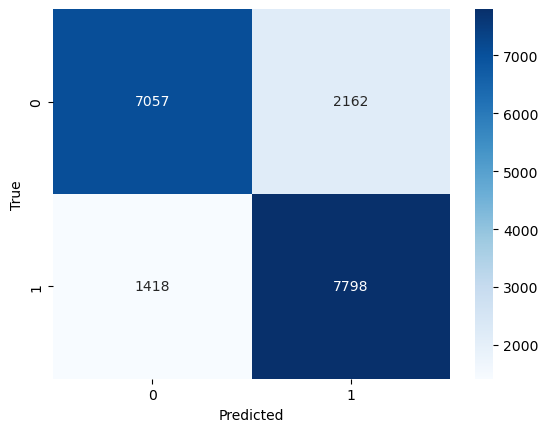

In [32]:
y_knn_pred = knn.predict(x_test_mm)
metricas(y_knn_pred, y_test)

# RandomForestClassifier

No se utiliza Scaler.
Primer GridSearch con:
```
{'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 15, 20],
              'min_samples_split': [2, 5, 10]}
```
arrojó los resultados:
```
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
```
Segundo GridSearch con:
```
{'n_neighbors': [17, 18, 19, 20, 21, 22, 23],
              'weights': ['distance'],
              'algorithm': ['kd_tree']}
```
arrojó los siguientes resuldaos:
```
{'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 110}
```

In [33]:
rf = RandomForestClassifier(max_depth=23, min_samples_split=2, n_estimators=110)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=23, n_estimators=110)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      9219
           1       0.88      0.88      0.88      9216

    accuracy                           0.88     18435
   macro avg       0.88      0.88      0.88     18435
weighted avg       0.88      0.88      0.88     18435



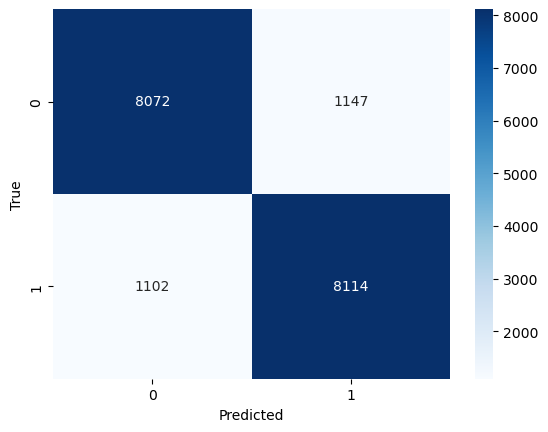

In [34]:
y_rf_pred = rf.predict(x_test)
metricas(y_rf_pred, y_test)

# XGBoost

In [39]:
#Separo un set de Evaluacion
x_train_Xg, x_test_Xg, y_train_Xg, y_test_Xg = train_test_split(df_hotels_train_encoded.values, 
                                                    df_target.values, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_target.values) #estratificado para mantener proporcion


print('# Datos Entrenamiento: {}'.format(len(x_train_Xg))) #- > cantidad de datos en cada set
print('# Datos Prueba: {}'.format(len(x_test_Xg)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_Xg,y_test_Xg]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

NameError: name 'df_target' is not defined

In [40]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train_Xg, y_train_Xg) #Entrenamos el modelo

ModuleNotFoundError: No module named 'xgboost'

In [41]:
y_pred_proba = xgb_model.predict_proba(x_test_Xg)[:, 1]
print('AUC:',roc_auc_score(y_test_Xg, y_pred_proba)) #mostramos el area bajo la curva

#Realizamos el pred y mostramos la matriz de confusion
y_pred_Xg = xgb_model.predict(x_test_Xg)

cm = confusion_matrix(y_test_Xg,y_pred_Xg)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Metricas
print(classification_report(y_test_Xg,y_pred_Xg))

NameError: name 'xgb_model' is not defined

Tenemos unas metricas bastante mas altas que el resto de ensambles en primera instancia. Este modelo es bastante mas potente que el resto de nuestros modelos hasta ahora.

Ahora, buscaremos llos hiperparametros para optimizar el modelo y conseguir un mejor rendimiento

In [ ]:
params_grid = {'n_estimators':range(20, 150, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)} #Hiper params que queremos mejorar

#Folds
kfoldcv = StratifiedKFold(n_splits=5)

#Metrica que buscamos mejorar 
scorer_fn = make_scorer(sk.metrics.f1_score) 


#Ramdom Search CV
clasificador = xgb.XGBClassifier()
randomcv = RandomizedSearchCV(clasificador, params_grid, n_jobs=-1, scoring = scorer_fn, cv=kfoldcv, n_iter=10, verbose = 1)
#randomcv.fit(x_train_Xg,y_train_Xg)

#print (randomcv.best_score_, randomcv.best_params_)

#Mejor Modelo
#gb = randomcv.best_estimator_